In [84]:
#https://github.com/Sentinel-5P/data-on-s3/blob/master/notebooks/Sentinel3_Tutorial.ipynb
import cartopy.crs as ccrs
import rasterio
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from rasterio.plot import show


In [110]:

# For convenience I have stored the COG file in the same directory as this notebook.
# Note you may have given the file a different name.
path_pc = 'C:/Users/Massimo/Documents/SchoolFolder/SentinelData/TIF_files/S3B_SL_2_LST____20210616T094035_20210616T094335_20210617T190722_0179_053_307_2340_LN2_O_NT_004_LST.tif' 
path_laptop = 'C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/SentinelData/TIF_files/S3B_SL_2_LST____20210616T094035_20210616T094335_20210617T190722_0179_053_307_2340_LN2_O_NT_004_LST.tif'
path_test_tif = 'C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/MassThesis/src/testTiff.tif'
path_geotest_tif = 'C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/MassThesis/src/myGeoTIFF.tif'
path_cropped_tif = 'C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/MassThesis/src/cropped.tif'

#when using .tif
raster = rasterio.open(path_cropped_tif)

#when using df product


# This will print out a short version of the  meta data associated with this file.
print(raster.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 64, 'height': 64, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.010635999999999979, 0.0, 14.067394999999973,
       0.0, -0.009772000000005221, 38.19258699999797)}


In [111]:
# Data visualization units.
#unit = '[ K ]'
unit = '[ °C ]'

long_name = 'Sentinel-3 Land Surface Temperature'

# We need to know the geographical extent of the data, this is contained in the raster object.

bbox = raster.bounds
extent=[bbox[0],bbox[2],bbox[1],bbox[3]]
#extent=[35.7, 36.1, 14.1, 14.6]
print (bbox)

BoundingBox(left=14.067394999999973, bottom=37.56717899999764, right=14.748098999999971, top=38.19258699999797)


In [112]:
from rasterio.enums import Resampling

upscale_factor = 1

# resample data to target shape
data = raster.read(
out_shape=(
    raster.count,
    int(raster.height * upscale_factor),
    int(raster.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
transform = raster.transform * raster.transform.scale(
(raster.width / data.shape[-1]),
(raster.height / data.shape[-2]))

print('Rescaled size: ',np.shape(data[0,:,:]))

Rescaled size:  (64, 64)


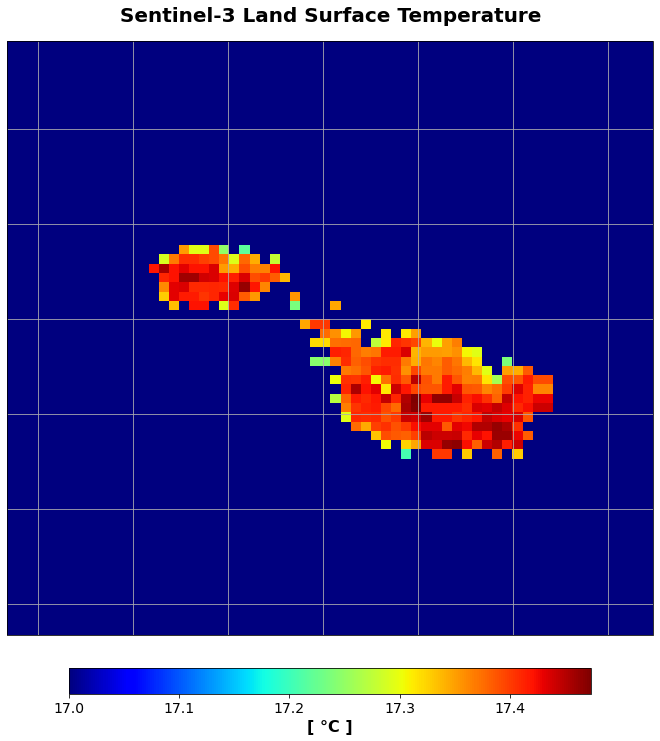

In [113]:
# Here we set up the parameters needed to display the geographical data correctly.
fig=plt.figure(figsize=(15, 12))

# Here we set up a simple Plate Carree geographical projection. This is handled by the Cartopy library.
#proj = ccrs.epsg(3857)
#ax = plt.axes(projection=proj)
ax = plt.axes(projection=ccrs.PlateCarree())

# The coastline data get downloaded here, there may be a delay the first time you run this notebook.

#ax.coastlines(resolution='10m')
ax.gridlines()
ax.set_title(long_name, fontsize=20, pad=20.0, fontweight = 'bold')

# Here we set the colour map for matplotlib. e.g. 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'jet', also
# selecting which colour to associate with the NODATA value in the map

color = cm.jet

color.set_bad('white')

#The pixel associated to the NODATA values are masked out.

data = data.astype(np.float16)
data[data == -32768.0] = np.nan

# As the product contains the data in Digital Numbers (DN), it is necessary to calibrate them with the SCALE FACTOR and OFFSET values.
# These can be retrieved from the extended metadata of the file. 

scale_factor = 0.0020000001

offset = 290

cal_data = scale_factor * data - 273 + offset

img = plt.imshow(cal_data[0,:,:], cmap = color,extent = extent,transform=ccrs.PlateCarree())

cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.05)
cbar.set_label(unit, fontsize=16, fontweight = 'bold')
cbar.ax.tick_params(labelsize=14)
plt.savefig('lst_cropped_snap.png')
plt.show()

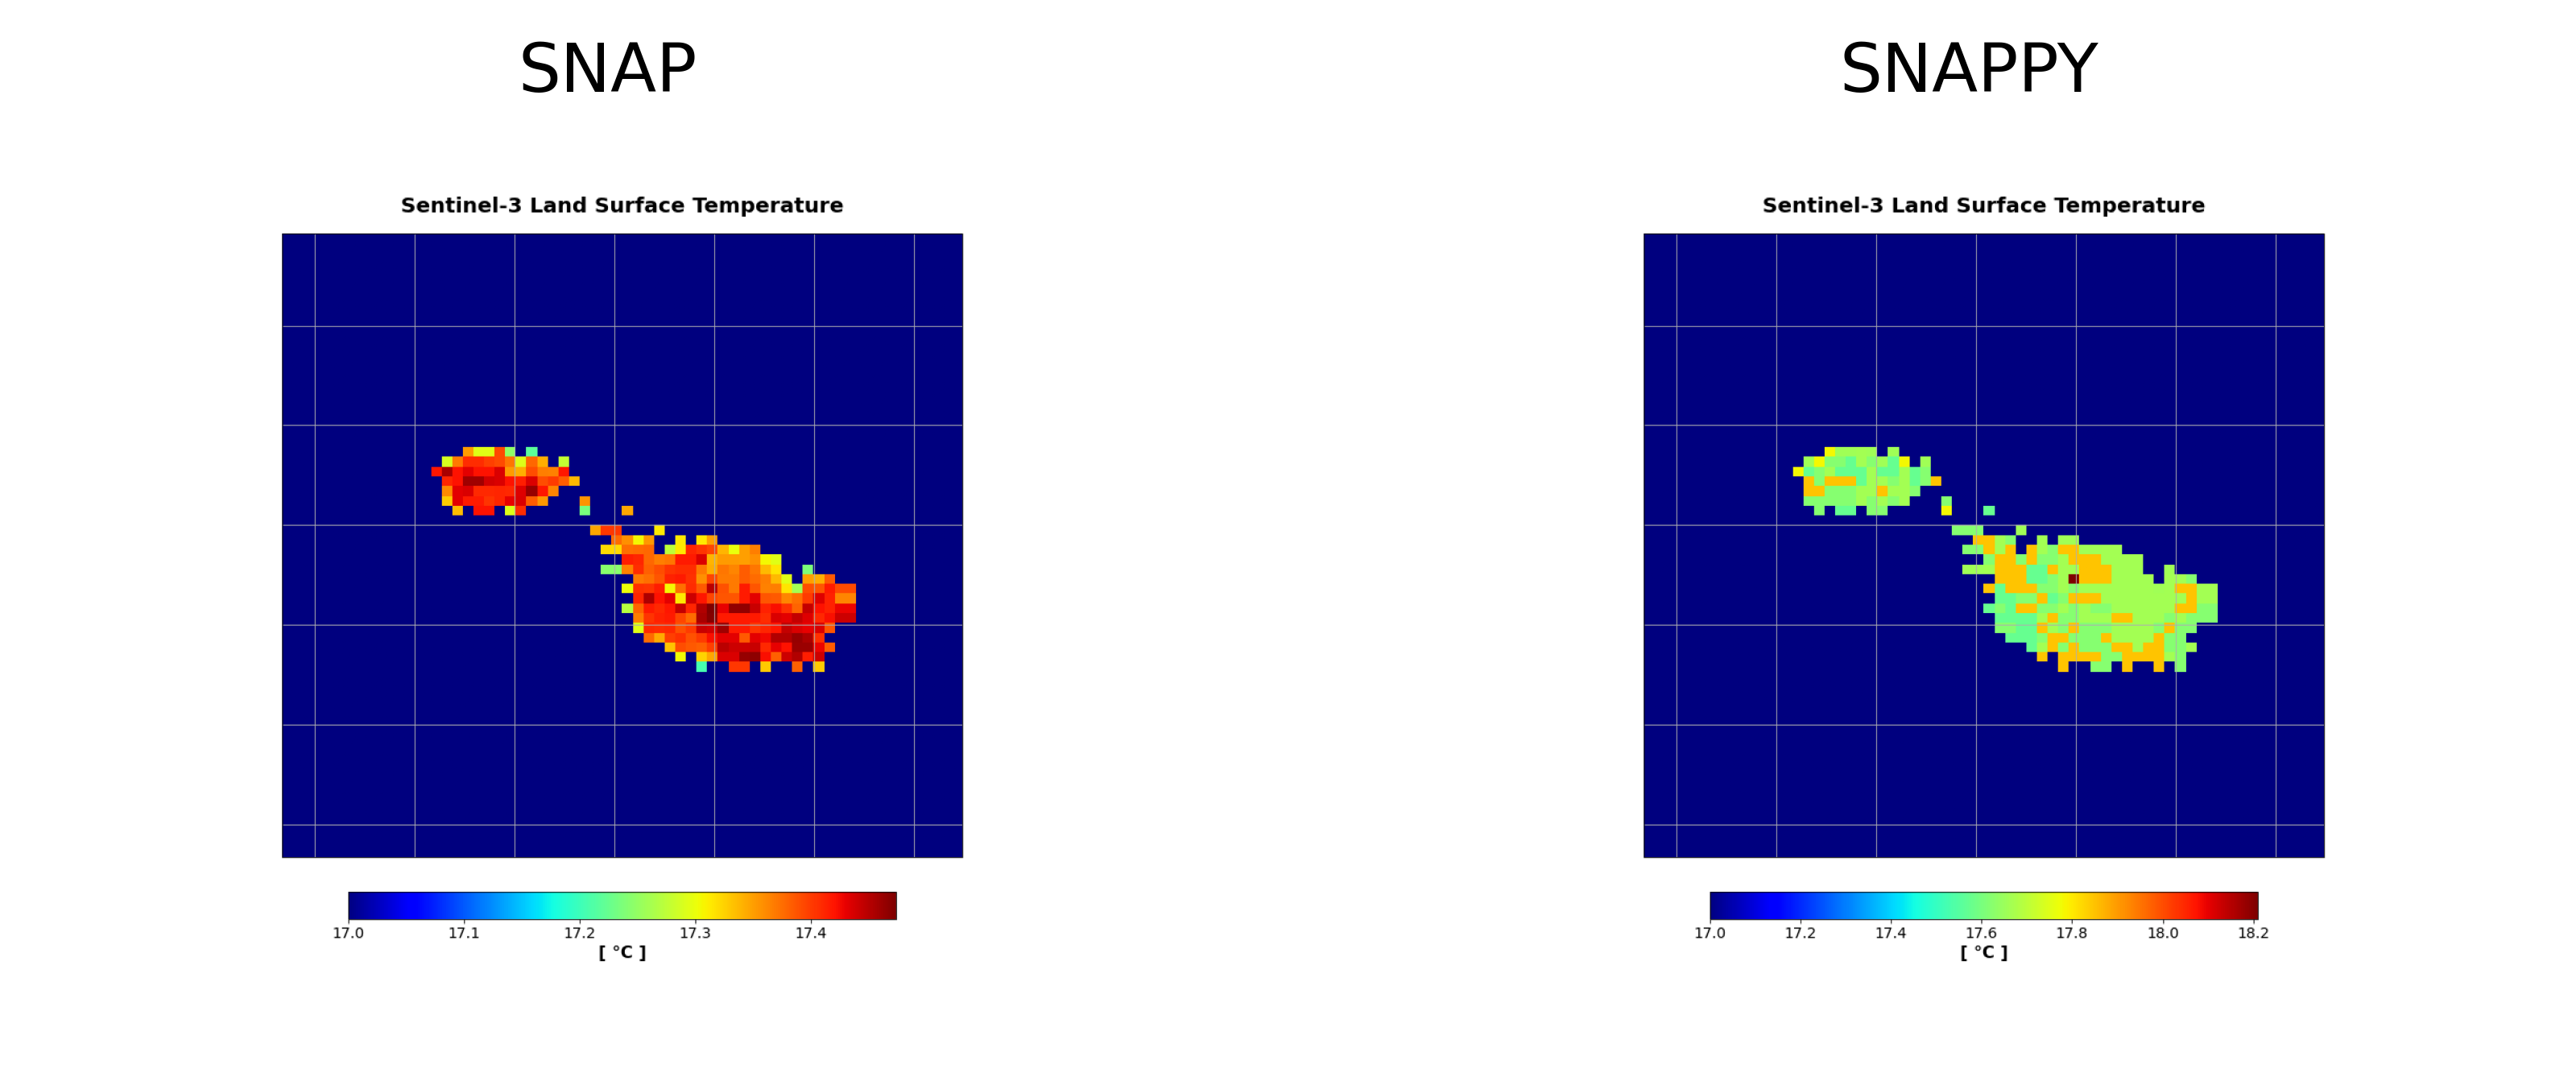

In [114]:
from matplotlib.pyplot import figure

snap_img = plt.imread('lst_cropped_snap.png')
snappy_img = plt.imread('lst_cropped_snappy.png')

figure(figsize=(8, 6), dpi=500)

plt.subplot(121)
plt.imshow(snap_img), plt.title('SNAP')
plt.axis('off')
plt.subplot(122)
plt.imshow(snappy_img), plt.title('SNAPPY')
plt.axis('off')
plt.savefig('comparing_crop.png')
plt.show()


In [1]:
plt.figure(figsize=(2, 3))
ax = plt.axes(projection=ccrs.OSNI())
ax.coastlines(resolution='10m')
ax.gridlines()
ax.set_title(long_name, fontsize=20, pad=20.0, fontweight = 'bold')


NameError: name 'plt' is not defined